In [50]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from grangercausality_test import GrangerCausalityTest
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.tsatools import lagmat2ds
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy import stats
from utils.utils import *
from statsmodels.tsa.vector_ar.var_model import VAR
path = '../stats_files/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
tb = os.listdir('../stats_files')
tb

['causality_networkx_graph.pickle',
 'causality_time_statistics.csv',
 'causation_in_out_data.csv',
 'correlation_time_statistics.csv',
 'corr_networkx_graph.pickle',
 'corr_table.csv',
 'directed_networkx_graph.pickle',
 'failure_data.csv',
 'full_causality_table.csv',
 'full_causality_table_labeled.csv',
 'stationary_percent.csv',
 'top_100_variables.csv']

In [52]:
df = pd.read_csv('../stats_files/full_causality_table.csv')
df.set_index(df.columns[0],inplace=True)

In [53]:
df.head()

,MODE_Mode,GPS_GCrs,GPS_Alt,GPS_NSats,GPS_Spd,GPS_Lat,GPS_Status,GPS_HDop,GPS_Lng,DU32_Id,...,RAD_RxErrors,RAD_RemNoise,RAD_Fixed,RAD_RSSI,RAD_Noise,RAD_TxBuf,RAD_RemRSSI,IMU_TimeMS,MAG_MagZ,MAG_OfsX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
MODE_Mode,NaN,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,NaN,...,NaN,0.0,NaN,0.0,1.0,0.0,NaN,NaN,1.0,NaN
GPS_GCrs,0.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,2.0,NaN,...,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0
GPS_Alt,1.0,0.0,NaN,1.0,1.0,1.0,2.0,1.0,2.0,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,NaN
GPS_NSats,1.0,0.0,1.0,NaN,1.0,1.0,0.0,2.0,1.0,NaN,...,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0
GPS_Spd,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,2.0,NaN


In [54]:
DG = nx.DiGraph()
DG.add_nodes_from(df.columns)
all_nodes = []
l_visited = []
for idx in df.index:  
    ltuples = [(idx,cl) for cl in df.columns[df.loc[idx] == 1] if idx != cl and (idx,cl) not in all_nodes]
    ltuples_bi = [(idx,cl) for cl in df.columns[df.loc[idx] == 2 ] if cl != idx and (idx,cl) not in all_nodes]
    l_visited = [(cl,idx) for cl in df.columns[df.loc[idx] == 1] if idx != cl]
    all_nodes += l_visited
    DG.add_edges_from(ltuples)
    DG.add_edges_from(ltuples_bi)
    ltuples = []
    ltuples_bi =[]
#save_as_pickle(DG,'../stats_files','causality_networkx_graph.pickle') #saving the graph to be used later for analysis

In [199]:
def get_connections(graph,variable,outgoing=False,incoming=False,plot=False):
    var = variable
    if outgoing and incoming:
        nd = list(set([e[1] for e in graph.out_edges(var)]) & set([e[0] for e in graph.in_edges(var)])) 
    elif outgoing:
        nd = [e[1] for e in graph.out_edges(var) if e[1] not in  [e[0] for e in graph.in_edges(var)]]
    elif incoming:
        nd = [e[0] for e in graph.in_edges(var) if e[0] not in  [e[1] for e in graph.out_edges(var)] ]
    else:
        return 0
    if plot:
        plt.figure(figsize=(7,5))
        H = graph.subgraph(nd+[var]).copy()
        pos = nx.spring_layout(H,k=0.3,iterations=10)
        pos[var] = np.array([0.11666525, 0.10171808])
        l = [e for e in H.edges if var not in e]
        H.remove_edges_from(l)
        nx.draw(G=H,pos=pos,with_labels=True,font_size=10,font_weight=10,label=var)
        plt.draw()
        plt.show()
    return nd

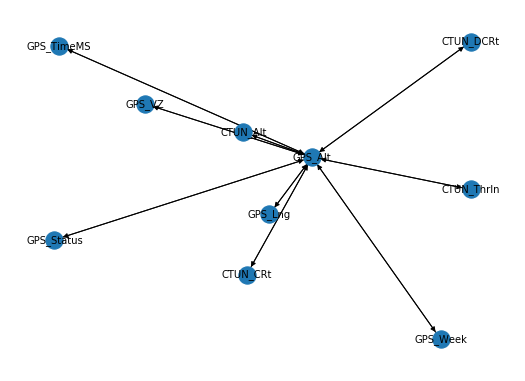

In [211]:
cnn = get_connections(DG,'GPS_Alt',outgoing=True,incoming=True,plot=True)

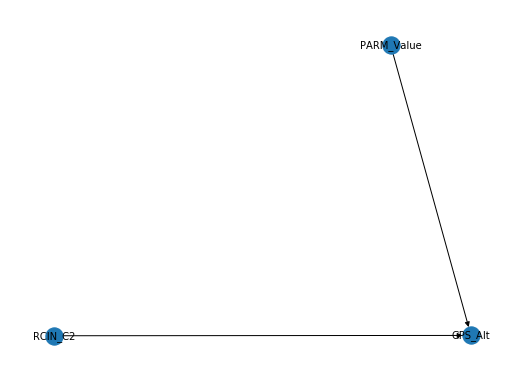

In [212]:
conn = get_connections(DG,'GPS_Alt',outgoing=False,incoming=True,plot=True)

In [202]:
stat_in_out = []
for c in df.columns:
    outgoing_count = len(get_connections(DG,c,outgoing=True,incoming=False,plot=False))
    incoming_count = len(get_connections(DG,c,outgoing=False,incoming=True,plot=False))
    both_count = len(get_connections(DG,c,outgoing=True,incoming=True,plot=False))
    stat_in_out.append((c,incoming_count,outgoing_count,both_count))
df_inout = pd.DataFrame(stat_in_out,columns=['signal','incoming','outgoing','both'])

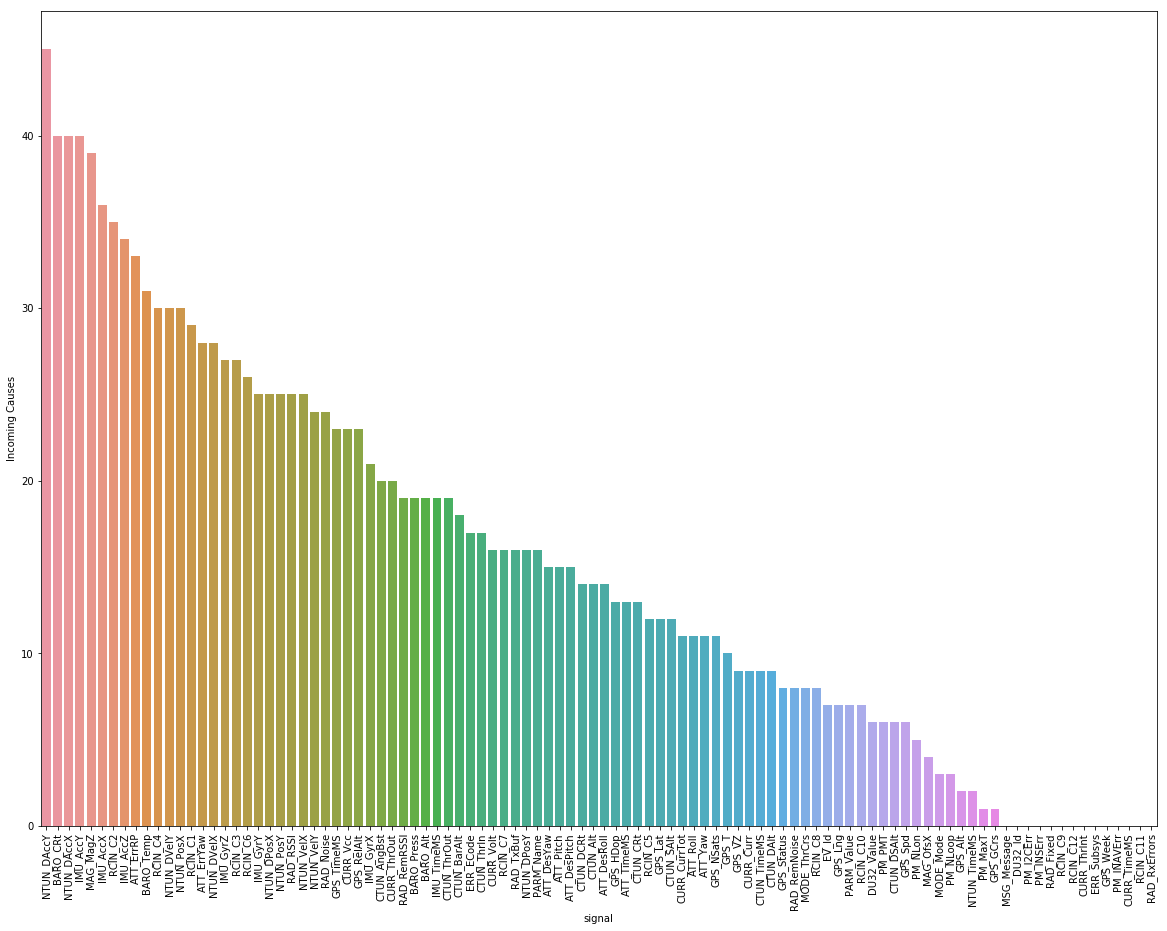

In [203]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='incoming',data=df_inout.sort_values('incoming',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('incoming',ascending=False).signal,rotation=90)
plt.ylabel('Incoming Causes') 
plt.show()
figure = g.get_figure()  
figure.savefig('../report/incoming_causation.png', dpi=500)

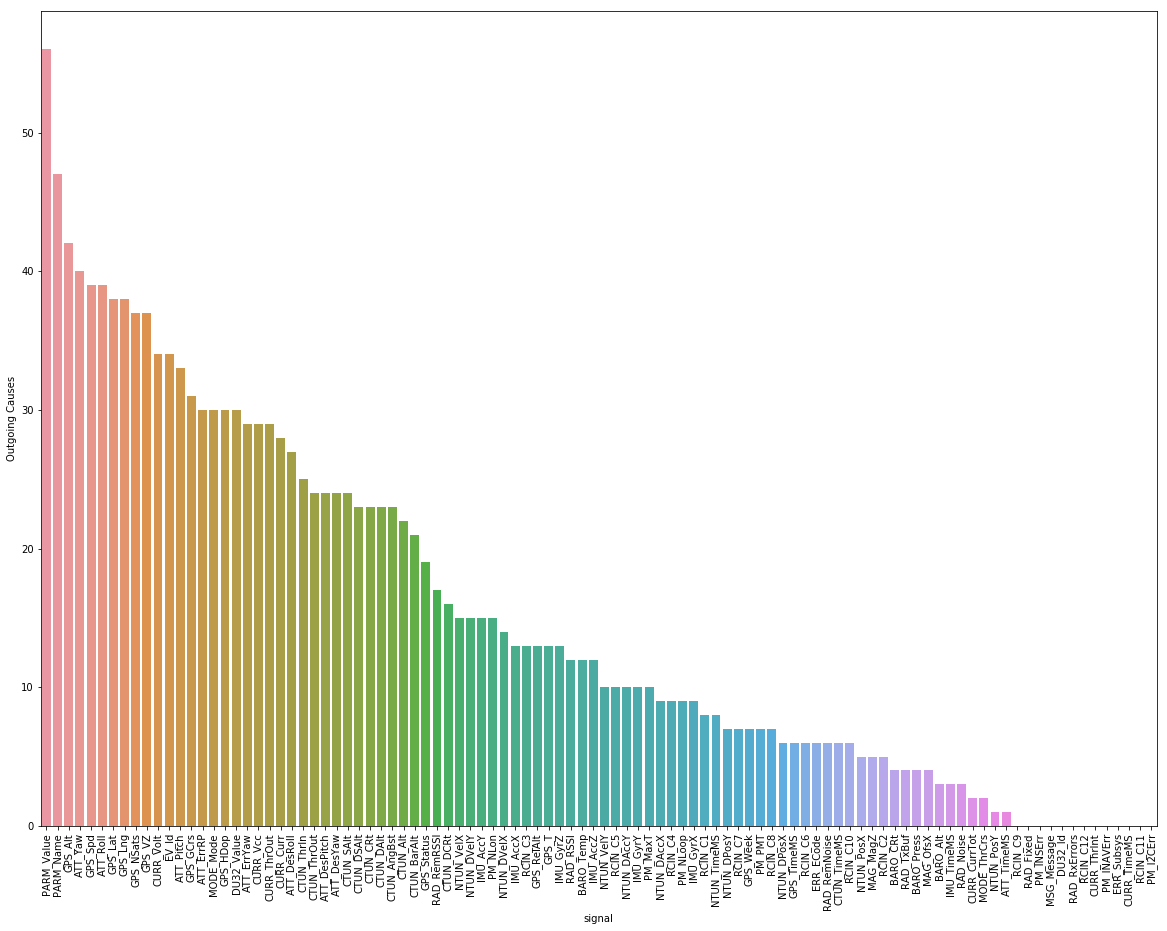

In [204]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='outgoing',data=df_inout.sort_values('outgoing',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('outgoing',ascending=False).signal,rotation=90)
plt.ylabel('Outgoing Causes')
plt.show()
figure = g.get_figure()  
figure.savefig('../report/outgoing_causation.png', dpi=500)

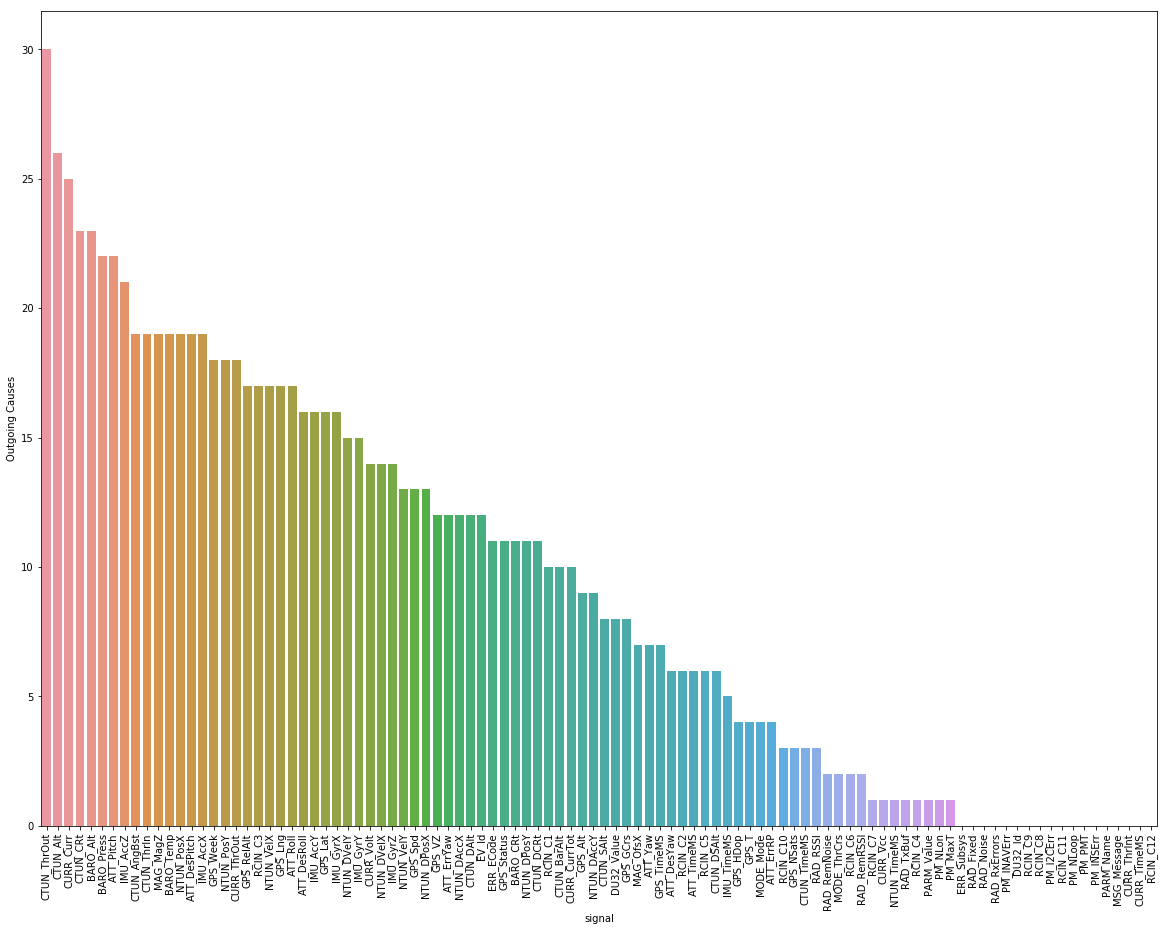

In [205]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='both',data=df_inout.sort_values('both',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('both',ascending=False).signal,rotation=90)
plt.ylabel('Outgoing Causes')
plt.show()
figure = g.get_figure()  
figure.savefig('../report/both_directions_causation.png', dpi=500)

In [207]:
df_inout.to_csv('../stats_files/causation_in_out_data.csv')

# Time Analysis

In [208]:
tm = pd.read_csv(path+'causality_time_statistics.csv')
tm = tm.sort_values('size MB',ascending=True).reset_index().drop(tm.columns[:2],axis=1)

In [209]:
tm.loc[len(tm)] = ('58c3e69a03d9b00f21696b11.log', 50.516817, 1349.1730382442474)

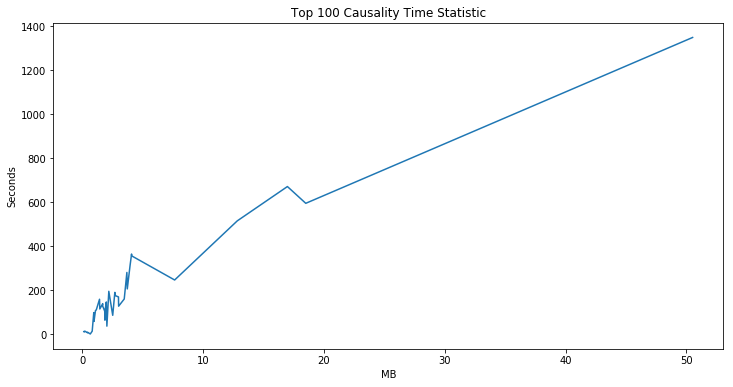

In [210]:
plt.figure(figsize=(12,6))
sns.lineplot(y='duration s',x='size MB',data=tm)
plt.ylabel('Seconds')
plt.xlabel('MB')
plt.title('Top 100 Causality Time Statistic')
plt.show()